# HEPMLC Basic Interface Example

This notebook provides an example interface to:
1. Select and configure physics model from ScannerS
2. Generate and analyze training data
3. Preprocess and split data
4. Train and evaluate multi-label classifier

All results will be saved in the Results directory.

The 'HEPMLC/notebooks' directory contains details on using HEPMLC to full capacity.

In [1]:
import os
import sys
from pathlib import Path

# Add src to path
sys.path.append('src')

# Setup directories
build_dir = os.path.dirname(os.getcwd())  # Go up one level from HEPMLC to build
scanner_path = os.path.join(build_dir, 'example_input')
results_dir = 'Results'
os.makedirs(results_dir, exist_ok=True)

# Import required modules. These are defined in /src.
from utils.model_reader import ModelReader
from utils.scanner_runner import ScannerRunner
from preprocessing.preprocessor import FeaturePreprocessor
from modeling.architecture import ModelBuilder
from modeling.trainer import ModelTrainer

2025-01-15 19:08:10.012256: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 19:08:10.405637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 19:08:10.406908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 19:08:11.522475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Available Models
Available models in ScannerS.

In [9]:
# List available models
model_reader = ModelReader(scanner_path=scanner_path)
print("Available Models:")
print("-" * 50)
for ini_file, clear_name in sorted(model_reader.get_available_models().items()):
    print(f"{clear_name} ({ini_file})")

Available Models:
--------------------------------------------------
Complex 2HDM Flipped (C2HDM_FL.ini)
Complex 2HDM Lepton Specific (C2HDM_LS.ini)
Complex 2HDM Type 1 (C2HDM_T1.ini)
Complex 2HDM Type 2 (C2HDM_T2.ini)
CP-Violating Dark Matter (CPVDM.ini)
Complex Singlet Broken Phase (CxSMBroken.ini)
Complex Singlet Dark (CxSMDark.ini)
N2HDM Broken Type 2 (N2HDMBroken_T2.ini)
N2HDM Dark D (N2HDMDarkD.ini)
N2HDM Dark SD (N2HDMDarkSD.ini)
N2HDM Dark S Type 1 (N2HDMDarkS_T1.ini)
Real 2HDM Flipped (R2HDM_FL.ini)
Real 2HDM Lepton Specific (R2HDM_LS.ini)
Real 2HDM Type 1 (R2HDM_T1.ini)
Real 2HDM Type 2 (R2HDM_T2.ini)
TRSM Broken Phase (TRSMBroken.ini)


## 2. Model Selection
Select a physics model from ScannerS and configure constraints.

In [18]:
# Select model and configure
selected_model = "N2HDMDarkD.ini"  # Change this to your chosen model
features, constraints = model_reader.read_model(selected_model)

print("\nFeatures and ranges:")
for feature, range_info in features.items():
    print(f"- {feature}: [{range_info['min']}, {range_info['max']}]")

print("\nConstraints:")
for constraint, value in constraints.items():
    print(f"- {constraint}: {value}")

#See /notebooks for more control, 
#or manually edit the initialization file in ScannerS


Features and ranges:
- mHa: [125.09, 125.09]
- mHb: [50.0, 1000.0]
- mHD: [1.0, 1500.0]
- mAD: [1.0, 1500.0]
- mHDp: [1.0, 1500.0]
- alpha: [-1.57, 1.57]
- m22sq: [0.001, 500000.0]
- L2: [0.0, 20.0]
- L8: [-30.0, 30.0]
- vs: [1.0, 1500.0]

Constraints:
- BfB: ignore
- Uni: ignore
- STU: ignore
- Higgs: ignore
- VacStab: skip
- DM: skip


## 3. Data Generation
Generate training data using ScannerS. See notebooks for more options.


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ~                                                        ~
 ~                   HiggsBounds 5.9.0                    ~
 ~                                                        ~
 ~             Philip Bechtle, Sven Heinemeyer,           ~
 ~              Tobias Klingl, Tim Stefaniak,             ~
 ~             Georg Weiglein, Jonas Wittbrodt            ~
 ~                                                        ~
 ~            arXiv:0811.4169, arXiv:1102.1898,           ~
 ~            arXiv:1301.2345, arXiv:1311.0055,           ~
 ~            arXiv:1507.06706                            ~
 ~       https://gitlab.com/higgsbounds/higgsbounds       ~
 ~                                                        ~
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 HiggsBounds collects together results from 

     * the LEP collaborations and LEP Higgs Working Group
     * the CDF and D0 Collaborations
     * the ATLAS 

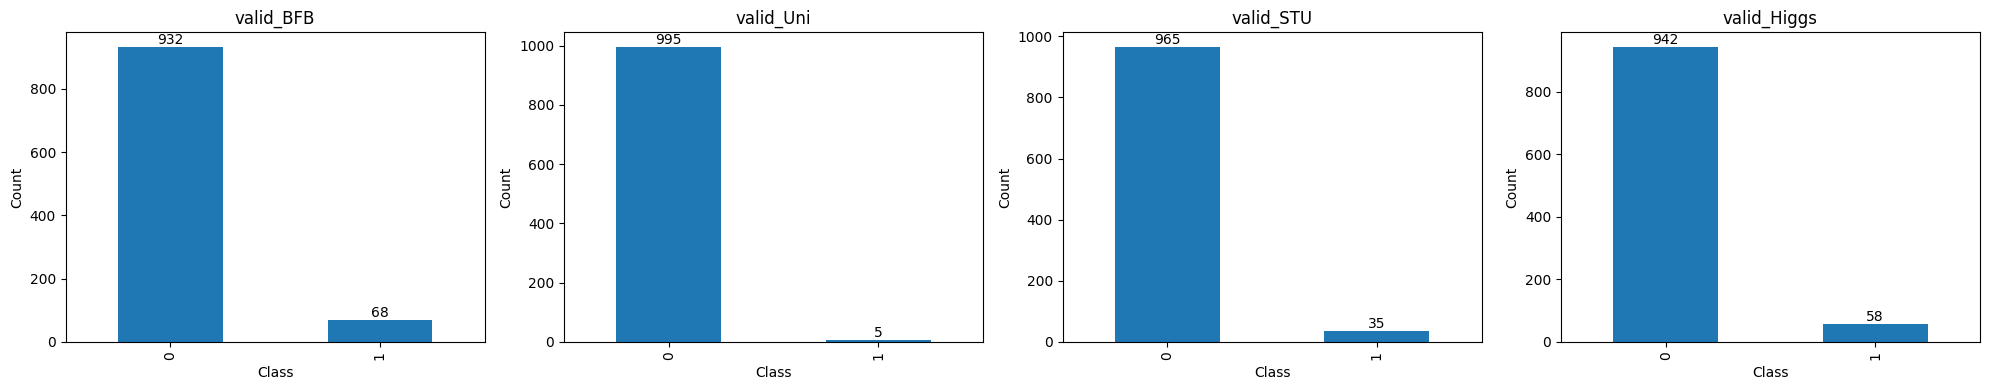

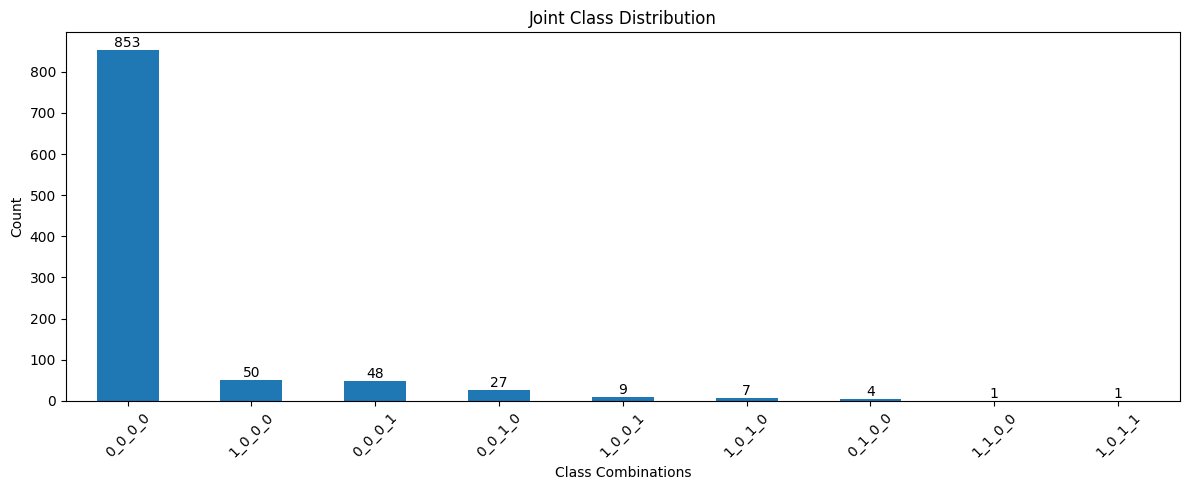

In [11]:
# Configure scan parameters
n_points = 1000  # Number of points to generate
output_file = os.path.join(build_dir, 'HEPMLC', results_dir, "scan_data.tsv")

# Run scan
scanner = ScannerRunner()
scanner.run_scan(selected_model, n_points, output_file)

# Analyze class balance
feature_cols = ['mH2', 'mHD', 'mAD', 'mHDp', 'alpha', 'L2', 'L8', 'vs', 'm22sq']
label_cols = ['valid_BFB', 'valid_Uni', 'valid_STU', 'valid_Higgs']

stats = scanner.analyze_class_balance(output_file, label_cols)
scanner.plot_class_distribution(stats, os.path.join(results_dir, 'class_distribution'))

## 3. Data Preprocessing and Splitting
Preprocess features and split data into train/validation/test sets.

In [13]:
# Load generated data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv(output_file, sep='\t')

# Configure preprocessing
apply_yj = True      # Apply Yeo-Johnson transformation
apply_scaler = True  # Apply Standard scaling

# Initialize preprocessor
preprocessor = FeaturePreprocessor(apply_yj=apply_yj, apply_scaler=apply_scaler)

# Split data (70-15-15)
X = data[feature_cols]
y = data[label_cols]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Save preprocessor
preprocessor.save_transformers(os.path.join(results_dir, 'preprocessor'))

Training set: 700 samples
Validation set: 150 samples
Test set: 150 samples


## 4. Model Configuration and Training
Configure and train the multi-label classifier. See notebooks for testing phase, and / or to perform experimentaion phase with Optuna.

In [19]:
# Model configuration (default parameters from paper)
model_params = {
    'n_layers': 2,
    'n_units_0': 64,
    'n_units_1': 128,
    'activation': 'relu',
    'dropout_rate': 0.01, #0.117,
    'apply_batch_norm': True,
    'optimizer': 'adam',
    'regularization': None,
    'reg_lambda': 0.05,
    'learning_rate': 0.000263,
    'batch_size': 64
}

# Training configuration
training_params = {
    'epochs': 15,
    'patience': 5,  # Early stopping patience
}

# Initialize model and trainer
builder = ModelBuilder(
    input_shape=(len(feature_cols),),
    num_outputs=len(label_cols)
)

trainer = ModelTrainer(
    model_builder=builder,
    feature_cols=feature_cols,
    label_cols=label_cols,
    output_dir=os.path.join(results_dir, 'model')
)

# Train model
model = trainer.train(
    X_train=X_train_processed,
    y_train=y_train,
    X_val=X_val_processed,
    y_val=y_val,
    params=model_params,
    epochs=training_params['epochs']
)

Epoch 1/15
11/11 [==============================] - 1s 23ms/step - loss: 0.4561 - subset_accuracy: 0.0372 - hamming_loss: 0.4866 - matthews_correlation: 0.0593 - macro_f1_score: 0.0921 - val_loss: 0.2243 - val_subset_accuracy: 0.0052 - val_hamming_loss: 0.6977 - val_matthews_correlation: 0.0321 - val_macro_f1_score: 0.0941
Epoch 2/15
11/11 [==============================] - 0s 7ms/step - loss: 0.3641 - subset_accuracy: 0.0498 - hamming_loss: 0.4830 - matthews_correlation: 0.0619 - macro_f1_score: 0.0920 - val_loss: 0.1999 - val_subset_accuracy: 0.0303 - val_hamming_loss: 0.5855 - val_matthews_correlation: 0.0086 - val_macro_f1_score: 0.0857
Epoch 3/15
11/11 [==============================] - 0s 6ms/step - loss: 0.3000 - subset_accuracy: 0.0669 - hamming_loss: 0.4676 - matthews_correlation: 0.0700 - macro_f1_score: 0.0976 - val_loss: 0.1799 - val_subset_accuracy: 0.0568 - val_hamming_loss: 0.4656 - val_matthews_correlation: 0.0024 - val_macro_f1_score: 0.0783
Epoch 4/15
11/11 [=========

## 5. Model Evaluation
Evaluate model performance on test set. See notebooks for more options.

In [20]:
# Evaluate on test set
trainer.evaluate(
    model=model,
    X_test=X_test_processed,
    y_test=y_test
)

print("\nAll results have been saved in the Results directory.")

5/5 [==============================] - 0s 1ms/step


/home/maien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maien/.local/lib/python3.10/site-packages/s


All results have been saved in the Results directory.
